# <center>Practical 09: Part 1 - Model Free RL</center>

<p style="color:#0000FF";> <b>Let's first make sure that all the required dependencies are installed (this is only needed if gym was not installed successfully all time) </b></p> 

### With pip (in your local machine)
1. Open Anaconda prompt
2. Type ``pip install gym``
3. If pip is missing, type ``conda install pip``

### In AWS
1. Add and execute the following line at the beginning of your notebook
```python 
import sys
!{sys.executable} -m pip install gym```

### Let us first import all the required dependencies

In [1]:
%matplotlib notebook

import matplotlib.pyplot as plt
import matplotlib.animation as animation
import numpy as np
import pickle
import math

import sys
import os
sys.path.insert(0, os.path.abspath('Support'))

from gym_simple_gridworlds.envs.grid_env import GridEnv
from gym_simple_gridworlds.envs.grid_2dplot import *
from gym_simple_gridworlds.helper import *
from gym_simple_gridworlds.dp_algorithms import *

from collections import namedtuple, defaultdict
import matplotlib.gridspec as gridspec

In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# 1. Monte Carlo Prediction Grid World Environment

<img src="Support/images/GridWorldExample.png" width="400" height="400" align="center">

- The states $s \in \mathcal{S}$ correspond to locations in the grid. Each location has also a cell index associated to it, e.g., cell index 4 is associated to location (1,0)
- The robot can move up, down, left, or right. Actions correpond to unit increments or decrements in the specified direction.
    - Up : (1,0)
    - Down: (-1,0)
    - Left: (0,-1)
    - Right: (0, 1)
- Each action is represented by a number. Action (Up) is represented by 0, (Down) by 1, (Left) by 2 and, finally, (Right) by 3. No actions are available at a terminal state
- Discount factor $\gamma = 0.9$ (class attribute ``gamma=0.9``)
- Stochastic transition matrix (class attribute ``noise=0.2``)
- Rewards are only obtained at terminal states (class attribute ``living_reward=0.0``)

### Known Dynamics

Recall the **optimal policy** we found using value-interation in the last lecture

<img src="Support/images/PolicyEvaluation.png" width="300" height="300" align="center">

since the dynamics of our grid world environment are known, we obtained the state-value function $v_\pi(s)$ associated to this policy using ``policy_evalution(.)`` (This method has been added to the support files)

<IPython.core.display.Javascript object>


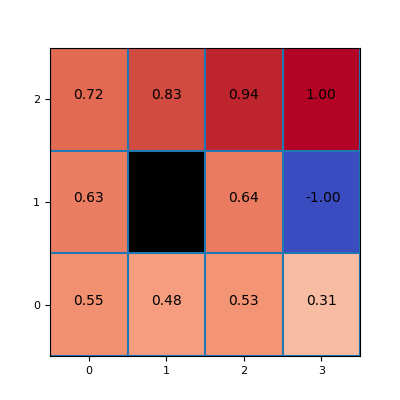

In [3]:
# Create a Grid World instance
grid_world = GridEnv(gamma=0.9, noise=0.2, living_reward=0)

# Get policy shown in image
policy_pi = encode_policy(grid_world)

# Compute value-function using dynamic programming
v_pi = policy_evaluation(grid_world, policy_pi)

plot_value_function(grid_world, v_pi)

### First Visit Monte Carlo Policy Evaluation 

Let's first define ``generate_episode(.)``, a samples an episode i.e., a sequence of ($s, a, r, s'$) tuples from a given policy

In [6]:
Sample = namedtuple('Sample', ['state', 'action', 'reward', 'next_state'])

def generate_episode(grid_env, policy):
    """
    Generate an episode of experiences in environment under a given policy
    :param grid_env (GridEnv): Environment
    :param policy (dict of probabilites): Policy used to sample actions
    
    :return List(Sample) Complete episode
    """
    episode = []

    # Reset the environment to a random initial state
    state = grid_env.reset()

    # Set flag to indicate whether episode has ended
    done = False

    while not done:
        # Get actions available at current state
        all_actions = list(policy_pi[state].keys())
        # Get action probabilities
        all_probabilities = np.array(list(policy[state].values()))
        # Sample an action from policy
        action = np.random.choice(all_actions, 1, p=all_probabilities)[0]
        
        next_state, reward, done, info = grid_env.step(action)
        episode.append(Sample(state, action, reward, next_state))
        state = next_state

    return episode

Now, under the assumption that $\mathcal{T}(s,a,s')$ and $\mathcal{R}(s,a)$ are unknown, let's use the algorithm shown below to get an estimate $\hat{v}_\pi(s)$ of the true state-value function $v_\pi(s)$

<img src="Support/images/MCPolicyEvaluation.png" width="500" height="500" align="center">

In [7]:
def monte_carlo_first_visit_policy_evaluation(grid_env, policy, true_v, n_episodes=1):
    """
    Compute estimate of state-value function for a given policy
    :param grid_env (GridEnv): Environment
    :param policy (dict of probabilites): Policy to be evaluated
    :param true_v (dict of floats): True state-value function. Used to compute prediciton error
    :param n_episodes (int): Number of episodes to use for prediction
    
    :return List(float): Prediction error after each episode
    :return dict(float): Predicted state-value function
    
    """
    all_states = grid_env.get_states()
    
    # Counter of visits for all states
    state_visits = {s:0 for s in all_states}
    # Cummulative return for each state
    state_returns = {s:0 for s in all_states}
    # Predicted state-value function
    pred_v = {s:0 for s in all_states}
    
    # Variable used for plotting
    list_errors = []
    
    for i in range(n_episodes):
        # Generate episode
        episode = generate_episode(grid_env, policy)
        # Create auxiliary variable to keep of first state visits
        visited = {s: False for s in all_states}
        # Return for current episode
        g = 0
        # Variable used to keep track of prediction error for this episode
        error = 0
        # Starting from last sampled observation in episode
        for obs in episode[::-1]:
            # Get visite state
            s = obs.state
            # Compute return for this state
            g = g*grid_env.gamma + obs.reward    
            # If this is the first time visiting this state
            if not visited[s]:
                # Increment the visit counter
                state_visits[s] += 1
                # Add return
                state_returns[s] += g
                # Compute mean return
                pred_v[s] = state_returns[s]/float(state_visits[s])
                # Compute error
                error += np.abs(true_v[s] - pred_v[s])
                # Set the state as visited
                visited[s] = True
        
        list_errors.append(error)
    
    return list_errors, pred_v

Let's now try the algorithm and compare its out to the true value-state function. 

**Interaction**:
Run the algorithm multiple times and observe what happens when the number of episodes increases.

<IPython.core.display.Javascript object>


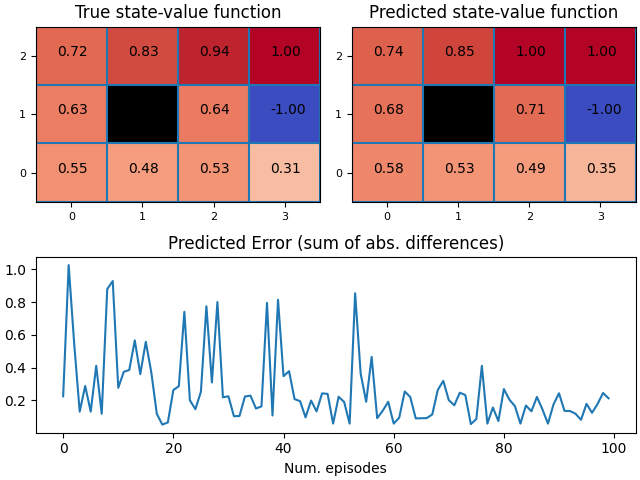

Text(0.5, 0, 'Num. episodes')

In [8]:
errors, predicted_v = monte_carlo_first_visit_policy_evaluation(grid_world, policy_pi, v_pi, n_episodes=100)

fig = plt.figure(constrained_layout=True)
spec = gridspec.GridSpec(ncols=2, nrows=2, figure=fig)
f_ax1 = fig.add_subplot(spec[0, 0])
f_ax2 = fig.add_subplot(spec[0, 1])
f_ax3 = fig.add_subplot(spec[1, :])

#Plot true value function
plot_value_function(grid_world, v_pi, f_ax1)
f_ax1.set_title("True state-value function")

plot_value_function(grid_world, predicted_v, f_ax2)
f_ax2.set_title("Predicted state-value function")

f_ax3.plot(errors)
f_ax3.set_title("Predicted Error (sum of abs. differences)")
f_ax3.set_xlabel("Num. episodes")

# 2. Exploration vs Exploitation

Last time, our agent was able to explore the environment thanks to the noise in the transition function $\mathcal{T}(s,a,s')$. However, in a model-free setting where our state-value and action-value estimates depend on the actions chosen by the agent, how can we guarantee that the all actions will continue to be selected?

Recall the definition of an $\epsilon$-greedy policy:

\begin{equation*}
\begin{aligned}
    \pi(a|s) = 
    \begin{cases}
        1 - \epsilon + \frac{\epsilon}{|\mathcal{A}|},&  \text{if } a^* = \arg\max_{a \in \mathcal{A}} q_\pi(s,a)\\
        \frac{\epsilon}{|\mathcal{A}|}, & \text{otherwise}
    \end{cases}
\end{aligned}
\end{equation*}

Let's see how the agent behaves when it follows an $\epsilon$-greedy policy.

In [9]:
def get_egreedy_action(grid_env, state, q_value, epsilon):
    """
    Select action to execute at a given state under an epsilon-greedy policy
    :param grid_env (GridEnv): Grid world environment
    :param state (int): Location in grid for which next action is going to be choosen
    :param q_value (dict): Action-value function 
    :param epsilon (float): Randomness threshold used to choose action
    """
    
    rand_n = np.random.random()
    if rand_n <= epsilon:
        return grid_env.action_space.sample()
    else:
        actions = list(q_value[state].keys())
        return actions[np.argmax(list(q_value[state].values()))]

<IPython.core.display.Javascript object>


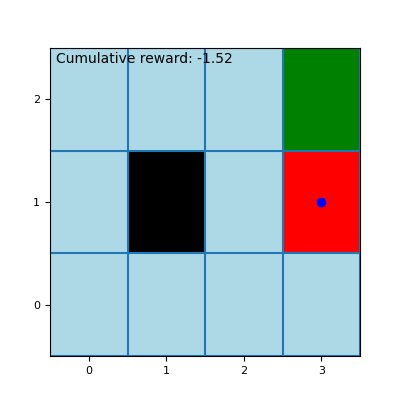

In [10]:
# We set noise to zero. Randomness in agent behaviour is only due to e-greedy policy
grid_world = GridEnv(noise=0, living_reward=-0.04, gamma=0.99)

# Get policy shown in section 1
policy_pi = encode_policy(grid_world)

# Compute value-function using dynamic programming
v_pi = policy_evaluation(grid_world, policy_pi)

# Use value-function to compute q-values
q_pi = grid_world.get_q_values(v_pi)

# Start episode
cur_state = grid_world.idx_cur_state
s_x, s_y = get_state_to_plot(grid_world)

# We can visualize our grid world using the render() function
fig, ax = grid_world.render()
agent, = ax.plot([], [], 'o', color='b', linewidth=6)
reward_text = ax.text(0.02, 0.95, '', transform=ax.transAxes)

done = False
cumulative_reward = 0
path_to_plot = []

v_epsilon = 0.8

while not done:
    action = get_egreedy_action(grid_world, cur_state, q_pi, v_epsilon)
    cur_state, cur_reward, done, _ = grid_world.step(int(action))
    n_x, n_y = get_state_to_plot(grid_world)
    cumulative_reward += cur_reward
    path_to_plot.append([cumulative_reward, n_x, n_y])

def init():
    agent.set_data(s_x + 0.5, s_y + 0.5)
    reward_text.set_text('')
    return agent, reward_text

def animate(i):
    if i < len(path_to_plot):
        r, n_x, n_y = path_to_plot[i]
        agent.set_data(n_x + 0.5, n_y + 0.5)
        reward_text.set_text('Cumulative reward: %.2f' % r)
    return agent, reward_text

ani = animation.FuncAnimation(fig, animate, frames=len(path_to_plot), blit=False, interval=500, init_func=init,
                              repeat=False)

**Interaction**:
- Change $\epsilon$ and observe how the agent behaviour changes.

**FLUX Question**: What happens as $\epsilon \rightarrow 0$? Compare the behaviour of the agent to the case in which the optimal policy is used instead as shown below

<IPython.core.display.Javascript object>


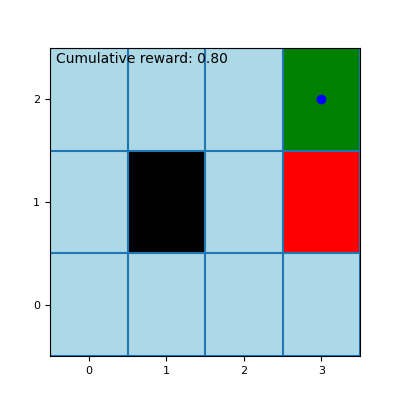

In [11]:
# We set noise to zero.
grid_world = GridEnv(noise=0, living_reward=-0.04, gamma=0.99)

# Get policy shown in section 1
policy_pi = encode_policy(grid_world)

# Start episode
cur_state = grid_world.idx_cur_state
s_x, s_y = get_state_to_plot(grid_world)

# We can visualize our grid world using the render() function
fig, ax = grid_world.render()
agent, = ax.plot([], [], 'o', color='b', linewidth=6)
reward_text = ax.text(0.02, 0.95, '', transform=ax.transAxes)

done = False
cumulative_reward = 0
path_to_plot = []

v_epsilon = 0.3

while not done:
    # Get actions available at current state
    all_actions = list(policy_pi[cur_state].keys())
    # Get action probabilities
    all_probabilities = np.array(list(policy_pi[cur_state].values()))
    # Pick an action
    action = np.random.choice(all_actions, 1, p=all_probabilities)[0]
    
    cur_state, cur_reward, done, _ = grid_world.step(int(action))
    n_x, n_y = get_state_to_plot(grid_world)
    cumulative_reward += cur_reward
    path_to_plot.append([cumulative_reward, n_x, n_y])

def init():
    agent.set_data(s_x + 0.5, s_y + 0.5)
    reward_text.set_text('')
    return agent, reward_text

def animate(i):
    if i < len(path_to_plot):
        r, n_x, n_y = path_to_plot[i]
        agent.set_data(n_x + 0.5, n_y + 0.5)
        reward_text.set_text('Cumulative reward: %.2f' % r)
    return agent, reward_text

ani = animation.FuncAnimation(fig, animate, frames=len(path_to_plot), blit=False, interval=500, init_func=init,
                              repeat=False)

# 3. Q-Learning

We have seen how to evaluate a policy without a model. Let's now find an *approximately* optimal policy using the off-policy control method Q-learning.

To help during the learning, we have added a lambda function that iteratively decreases epsilon. Our agent will strongly explore the environment at first to then swicth into exploitation mode

In [12]:
min_epsilon=0.001
max_epsilon=1.0
epsilon_decay = 80.0
epsilon_by_episode = lambda ep_idx: min_epsilon + (max_epsilon - min_epsilon) * math.exp (-1 * ep_idx/epsilon_decay)

<IPython.core.display.Javascript object>


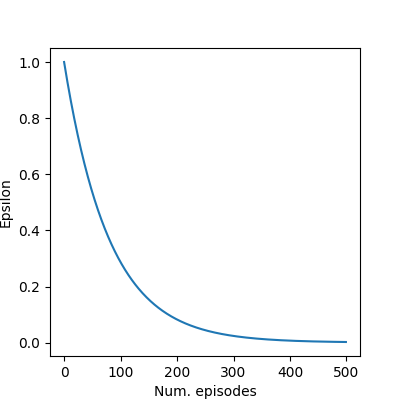

Text(0, 0.5, 'Epsilon')

In [13]:
fig, ax = plt.subplots(figsize=(4, 4))

ax.plot([epsilon_by_episode(i) for i in range(500)])
ax.set_xlabel("Num. episodes")
ax.set_ylabel("Epsilon")

Here is our implementation of the q-learning algorithm shown below

<img src="Support/images/q-learning.png" width="500" height="500" align="center">

**Complete the missing steps**:
- Choose an action using an $\epsilon$-greedy policy (use the function ``get_egreedy_action(.)`` we tested in section 2)
- Update our q-function using a greedy (max) policy (use ``q_function[cur_state][action]`` to index our q-function)

In [14]:
def q_learning(grid_env, alpha=0.1, min_epsilon=0.01, max_epsilon=1.0, 
               epsilon_decay = 80.0, n_episodes=500):
    """
    This function computes an approximately optimal policy using q-learning
    
    :param grid_env (GridEnv): MDP environment
    :param alpha (float): step-size
    :param epsilon (float): value used during e-greedy action selection
    :return: (dict) State-values for all non-terminal states
    """
        
    # This lambda function iteratively decreases epsilon
    epsilon_by_episode = lambda ep_idx: min_epsilon + (max_epsilon - min_epsilon) * math.exp (-1 * ep_idx/epsilon_decay)
    
    # Obtain list of all states in environment
    states = grid_env.get_states()
    actions = grid_env.get_actions()
    q_function = defaultdict(lambda: defaultdict(float))
    
    for s in states:
        for a in actions:
            q_function[s][a] = 0
    
    
    for i_episode in range(1, n_episodes+1):
        cur_state = grid_env.reset()
        done = False
        epsilon = epsilon_by_episode(i_episode)
        
        while not done:
            # TODO 1: Complete off-policy action selection (e-greedy)
            action = get_egreedy_action(grid_env, cur_state, q_function, epsilon)
            
            next_state, reward, done,_ = grid_env.step(action)
            q_next_state = list(q_function[next_state].values())
            
            # TODO 2: Complete update of q-function
            q_function[cur_state][action] += alpha * (reward + grid_env.gamma * np.max(q_next_state) - q_function[cur_state][action])
            
            cur_state=next_state
    
    return decode_policy(grid_env, q_function)

Let's now test our implementation and compare our free-model policy with the one we obtained in the last lecture using value iteration

In [15]:
grid_world = GridEnv(gamma=0.9, noise=0.2, living_reward=-0.04)
q_learning_policy = q_learning(grid_world)

<IPython.core.display.Javascript object>


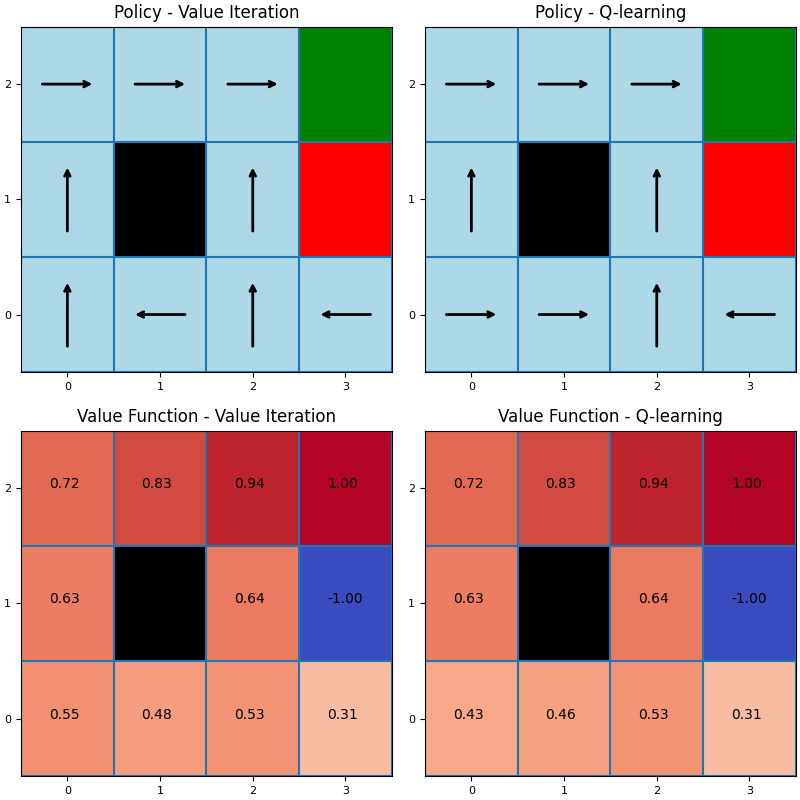

Text(0.5, 1.0, 'Value Function - Q-learning')

In [16]:
fig = plt.figure(figsize=(8, 8), constrained_layout=True)
spec = gridspec.GridSpec(ncols=2, nrows=2, figure=fig)
f_ax1 = fig.add_subplot(spec[0, 0])
f_ax2 = fig.add_subplot(spec[0, 1])
f_ax3 = fig.add_subplot(spec[1, 0])
f_ax4 = fig.add_subplot(spec[1, 1])

#Plot policy obtained using value-iteration value function
grid_world = GridEnv(gamma=0.9, noise=0.2, living_reward=0)
value_function, optimal_policy = value_iteration(grid_world)

plot_policy(grid_world, optimal_policy, f_ax1)
f_ax1.set_title("Policy - Value Iteration")

plot_policy(grid_world, q_learning_policy, f_ax2)
f_ax2.set_title("Policy - Q-learning")

# Compute value function for q_learning policy
q_policy_state_values = policy_evaluation(grid_world, encode_policy(grid_world, q_learning_policy))

plot_value_function(grid_world, value_function, f_ax3)
f_ax3.set_title("Value Function - Value Iteration")

plot_value_function(grid_world, q_policy_state_values, f_ax4)
f_ax4.set_title("Value Function - Q-learning")

**Flux Question**: What is the main difference between the two policies? Is the q-learning policy optimal?